# **Load Data**

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
import requests, zipfile, io


# download link for the dataset
FILE_DOWNLOAD_URL = "http://cicresearch.ca/CICDataset/CIC-IDS-2017/Dataset/CIC-IDS-2017/CSVs/GeneratedLabelledFlows.zip"
response = requests.get(FILE_DOWNLOAD_URL)
dfs = []

# unzip the downloaded file
with zipfile.ZipFile(io.BytesIO(response.content)) as z:
    # skip the first folder name
    for file in z.namelist()[1:]:
        print(f"Loading {file}...")
        with z.open(file) as f:
            # reading first 50k rows from each file just for testing
            dfs.append(pd.read_csv(f, encoding='cp1252', nrows=50000))

# combine all data into a single DataFrame
df = pd.concat(dfs, ignore_index=True)
print("Data loaded:", df.shape)


Loading TrafficLabelling /Wednesday-workingHours.pcap_ISCX.csv...
Loading TrafficLabelling /Tuesday-WorkingHours.pcap_ISCX.csv...
Loading TrafficLabelling /Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv...
Loading TrafficLabelling /Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv...
Loading TrafficLabelling /Monday-WorkingHours.pcap_ISCX.csv...
Loading TrafficLabelling /Friday-WorkingHours-Morning.pcap_ISCX.csv...
Loading TrafficLabelling /Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv...
Loading TrafficLabelling /Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv...
Data loaded: (400000, 85)


# **Data Cleaning**

In [7]:
df.columns = df.columns.str.strip()   # remove extra spaces in column names
df.fillna(0, inplace=True)           # fill missing values
X = df.drop(columns=['Label', 'Flow ID', 'Source IP', 'Destination IP', 'Timestamp'])
y = df['Label']

# replace infinite values
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.fillna(0, inplace=True)


In [8]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [9]:
# Handle Class Imbalance
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X_train, y_train)


In [10]:
# Feature Scaling
scaler = StandardScaler()
X_res_scaled = scaler.fit_transform(X_res)
X_test_scaled = scaler.transform(X_test)


# **Hyperparameter Tuning**

In [11]:
param_grid = {'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]}
gnb = GaussianNB()
grid = GridSearchCV(gnb, param_grid, cv=5, scoring='f1_weighted')
grid.fit(X_res_scaled, y_res)
best_var_smoothing = grid.best_params_['var_smoothing']
print("Best var_smoothing:", best_var_smoothing)

Best var_smoothing: 1e-09


In [12]:
# Train Naive Bayes Model
nb = GaussianNB(var_smoothing=best_var_smoothing)
nb.fit(X_res_scaled, y_res)


GaussianNB()


--- Standard Evaluation ---
Classification Report (Sklearn):

                          precision    recall  f1-score   support

                  BENIGN       1.00      0.89      0.94     73393
                     Bot       0.00      0.00      0.00         0
                    DDoS       0.82      0.98      0.90      4773
           DoS slowloris       0.17      0.94      0.28       532
             FTP-Patator       0.93      1.00      0.96      1039
                PortScan       0.01      0.96      0.02        47
Web Attack – Brute Force       0.16      0.98      0.28       216

                accuracy                           0.89     80000
               macro avg       0.44      0.82      0.48     80000
            weighted avg       0.98      0.89      0.93     80000



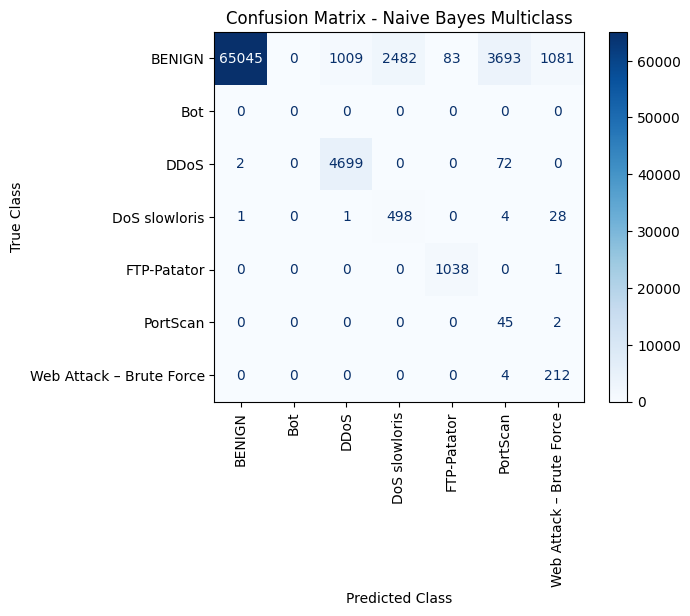

In [22]:
# make predictions and get probabilities for ROC curves
y_pred = nb.predict(X_test_scaled)
y_score = nb.predict_proba(X_test_scaled)
classes = nb.classes_

# Standard Evaluation and Confusion Matrix (Verified Output)
print("\n--- Standard Evaluation ---")

# print main classification report
print("Classification Report (Sklearn):\n")

# use correct class order and avoid zero division warnings
print(classification_report(y_test, y_pred, labels=classes, zero_division=0))

# build confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=classes)

# show confusion matrix as a plot with labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.title("Confusion Matrix - Naive Bayes Multiclass")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()

In [23]:

# Manual Metric Verification (Addressing Inconsistency Concern)
metrics_dict = {'class': [], 'precision': [], 'recall': [], 'f1-score': [], 'support': []}
for i, class_name in enumerate(classes):
    TP = cm[i, i]
    # Sum of the column minus the TP (False Positives)
    FP = cm[:, i].sum() - TP
    # Sum of the row minus the TP (False Negatives)
    FN = cm[i, :].sum() - TP
    support = cm[i, :].sum()

    # Calculate metrics, handling division by zero
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

    metrics_dict['class'].append(class_name)
    metrics_dict['precision'].append(round(precision, 2))
    metrics_dict['recall'].append(round(recall, 2))
    metrics_dict['f1-score'].append(round(f1, 2))
    metrics_dict['support'].append(support)

metrics_df = pd.DataFrame(metrics_dict)
metrics_df.set_index('class', inplace=True)
print("Classification Report (Manual Calculation Verification):")
print(metrics_df)
accuracy = np.trace(cm) / np.sum(cm)
print(f"\nOverall Accuracy (Verified): {round(accuracy, 2)}")



Classification Report (Manual Calculation Verification):
                          precision  recall  f1-score  support
class                                                         
BENIGN                         1.00    0.89      0.94    73393
Bot                            0.00    0.00      0.00        0
DDoS                           0.82    0.98      0.90     4773
DoS slowloris                  0.17    0.94      0.28      532
FTP-Patator                    0.93    1.00      0.96     1039
PortScan                       0.01    0.96      0.02       47
Web Attack – Brute Force       0.16    0.98      0.28      216

Overall Accuracy (Verified): 0.89


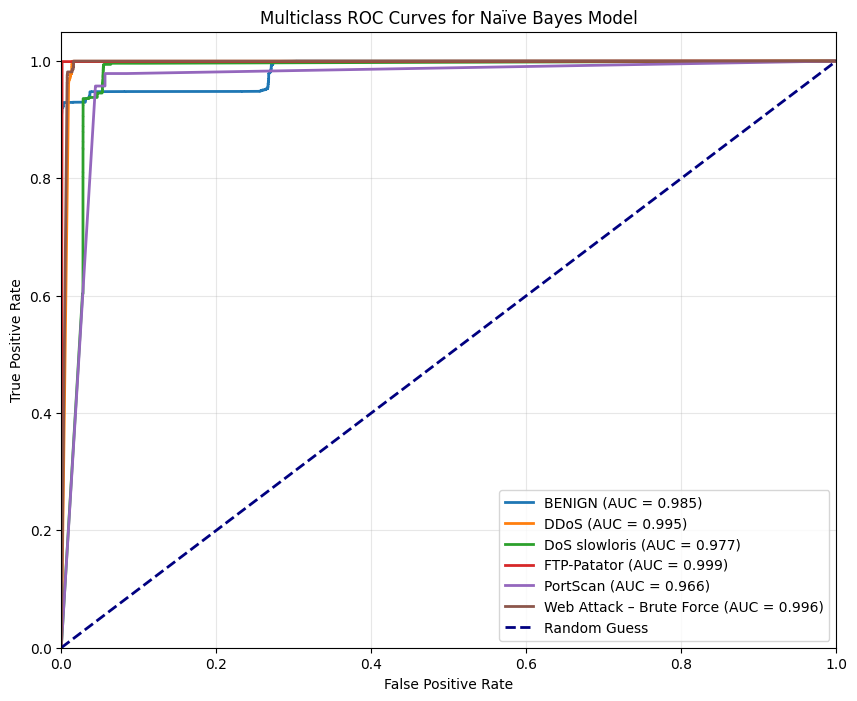


Verified ROC AUC per class:
BENIGN: 0.985
DDoS: 0.995
DoS slowloris: 0.977
FTP-Patator: 0.999
PortScan: 0.966
Web Attack – Brute Force: 0.996


In [24]:
#  Multiclass ROC AUC Evaluation and Plotting

# convert test labels to binary (one-vs-rest)
y_test_bin = label_binarize(y_test, classes=classes)

roc_auc_dict = {}
plt.figure(figsize=(10, 8))

for i, class_name in enumerate(classes):
    # skip if class not found in test set
    if np.sum(y_test_bin[:, i]) == 0:
        roc_auc_dict[class_name] = np.nan
        continue

    # get fpr/tpr and AUC for each class
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    roc_auc_dict[class_name] = roc_auc

    # plot ROC curve with class name and AUC
    plt.plot(fpr, tpr, lw=2, label=f'{class_name} (AUC = {roc_auc:.3f})')

# plot diagonal line for random guess
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curves for Naïve Bayes Model')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

# print AUC values for each class
print("\nVerified ROC AUC per class:")
for cls, auc_val in roc_auc_dict.items():
    if not np.isnan(auc_val):
        print(f"{cls}: {auc_val:.3f}")
